## 2.3 1D Convolutional Neural Network Models for Human Activity Recognition

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right\"> Initial upload: 2022.4.26 </div>
<div style="text-align: right\"> Last update: 2022.4.26</div>

- 출처 : https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

from scipy.signal import find_peaks

In [2]:
colors = ["#00798c", "#d1495b", '#edae49', '#66a182', '#4a4a4a',
          '#1a508b', '#e3120b', '#c5a880', '#9F5F80', '#6F9EAF',
          '#0278ae','#F39233', '#A7C5EB', '#54E346', '#ABCE74',
        '#d6b0b1', '#58391c', '#cdd0cb', '#ffb396', '#6930c3']
sns.color_palette(colors[:10])

[(0.0, 0.4745098039215686, 0.5490196078431373),
 (0.8196078431372549, 0.28627450980392155, 0.3568627450980392),
 (0.9294117647058824, 0.6823529411764706, 0.28627450980392155),
 (0.4, 0.6313725490196078, 0.5098039215686274),
 (0.2901960784313726, 0.2901960784313726, 0.2901960784313726),
 (0.10196078431372549, 0.3137254901960784, 0.5450980392156862),
 (0.8901960784313725, 0.07058823529411765, 0.043137254901960784),
 (0.7725490196078432, 0.6588235294117647, 0.5019607843137255),
 (0.6235294117647059, 0.37254901960784315, 0.5019607843137255),
 (0.43529411764705883, 0.6196078431372549, 0.6862745098039216)]

In [3]:
def load_file(filepath):
    df = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return df.values

In [4]:
data = load_file('data/UCI HAR Dataset/train/Inertial Signals/total_acc_y_train.txt')

In [6]:
data.shape

(7352, 128)

다음 단계는 파을 그룹을 로드한다.....   

시계열에서는 다음과 같은 구조로 데이터가 되어 있어야 한다.  
데이터를 3D로 만든다.

[samples, timesteps, features]

In [7]:
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = np.dstack(loaded)
	return loaded

In [8]:
filenames = ['total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']
total_acc = load_group(filenames, prefix='data/UCI HAR Dataset/train/Inertial Signals/')
print(total_acc.shape)

(7352, 128, 3)


- 세번째 축으로 결합하여 3차원을 만듬

이제 두 함수를 사용하여 학습용, 시험용 데이터셋을 로드하는 함수를 만든다.

In [9]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

마지막으로 학습, 시험용 데이터를 만드는 함수이다. 여기에는 카테고리 인코딩, 정규화 부분 등도 있다.

In [11]:
from tensorflow.keras.utils import to_categorical

In [12]:
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'data/UCI HAR Dataset/')
	print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'data/UCI HAR Dataset/')
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy

### Fit and Evaluate Model

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model

In [16]:
def evaluate_model(trainX, trainy, testX, testy):
	verbose, epochs, batch_size = 0, 10, 32
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1] 
	model = Sequential()
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
	model.add(Dropout(0.5))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy

### Summearize Results

In [21]:
# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = np.mean(scores), np.std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [22]:
# run an experiment
def run_experiment(repeats=10):
	# load data
	trainX, trainy, testX, testy = load_dataset()
	# repeat experiment
	scores = list()
	for r in range(repeats):
		score = evaluate_model(trainX, trainy, testX, testy)
		score = score * 100.0
		print('>#%d: %.3f' % (r+1, score))
		scores.append(score)
	# summarize results
	summarize_results(scores)

In [23]:
run_experiment()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
>#1: 89.650
>#2: 88.599
>#3: 90.295
>#4: 90.838
>#5: 89.175
>#6: 89.515
>#7: 91.110
>#8: 90.601
>#9: 91.483
>#10: 88.022
[89.65049386024475, 88.59857320785522, 90.29521346092224, 90.83814024925232, 89.17543292045593, 89.51476216316223, 91.10960364341736, 90.60060977935791, 91.48286581039429, 88.021719455719]
Accuracy: 89.929% (+/-1.070)


### 튜닝하기

#### Data preparation

원본 데이터가 -1 ~1 범위로 스케일 되어있다. 그런데 이 것이 잘된 것인지는 알수 없다.   

따라서 정규분포로 스케일링하는 것이 도움이 될 수 있다.    

각 변수의 분포는 히스토그램을 통해 확인 가능하다.  

그런데 데이터가 128개 스텝으로 쪼개져 있어서, 그리고 50%가 오버랩 되어서, 중복부분을 제거하고 윈도우도 제거해야한다.

이를 반영한 분포 확인 함수는 다음과 같다.

In [24]:
def plot_variable_distributions(trainX):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	print(longX.shape)
	plt.figure(figsize = (16, 12))
	xaxis = None
	for i in range(longX.shape[1]):
		ax = plt.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
		ax.set_xlim(-1, 1)
		if i == 0:
			xaxis = ax
		plt.hist(longX[:, i], bins=100)
	plt.show()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
(470528, 9)


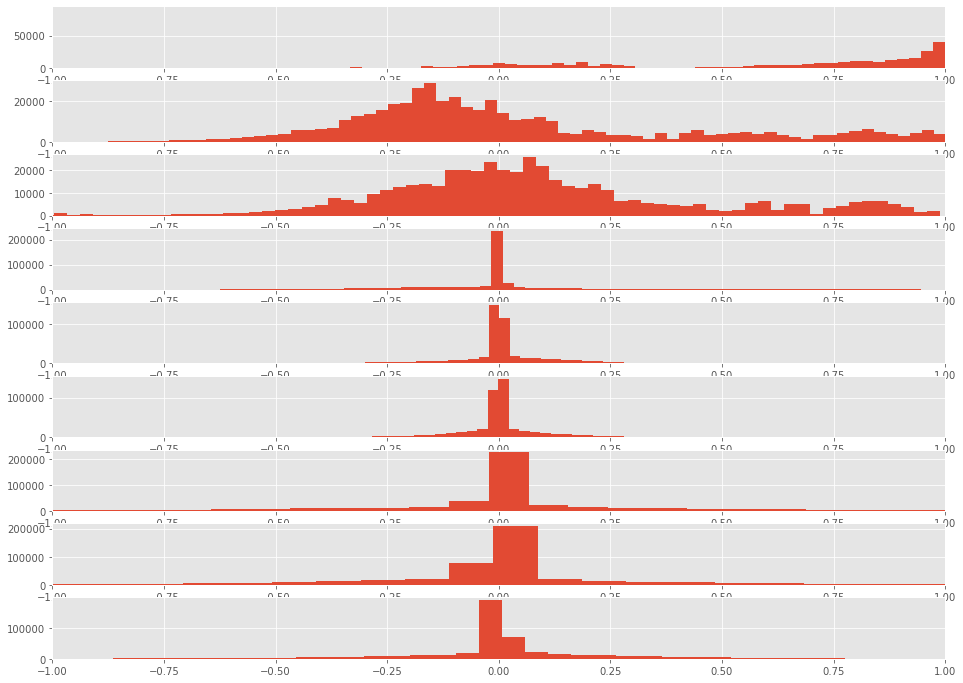

In [25]:
# load data
trainX, trainy, testX, testy = load_dataset()
# plot histograms
plot_variable_distributions(trainX)

위에서 부터 순서대로   

- Total Acceleration x
- Total Acceleration y
- Total Acceleration z
- Body Acceleration x
- Body Acceleration y
- Body Acceleration z
- Body Gyroscope x
- Body Gyroscope y
- Body Gyroscope z

이제 스케일링하는 함수를 만들어보자.

In [26]:
from sklearn.preprocessing import StandardScaler

In [27]:
def scale_data(trainX, testX, standardize):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	# flatten train and test
	flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
	flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))
	# standardize
	if standardize:
		s = StandardScaler()
		# fit on training data
		s.fit(longX)
		# apply to training and test data
		longX = s.transform(longX)
		flatTrainX = s.transform(flatTrainX)
		flatTestX = s.transform(flatTestX)
	# reshape
	flatTrainX = flatTrainX.reshape((trainX.shape))
	flatTestX = flatTestX.reshape((testX.shape))
	return flatTrainX, flatTestX

In [28]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, param):
	verbose, epochs, batch_size = 0, 10, 32
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	# scale data
	trainX, testX = scale_data(trainX, testX, param)
	model = Sequential()
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
	model.add(Dropout(0.5))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy

In [30]:
# summarize scores
def summarize_results(scores, params):
	print(scores, params)
	# summarize mean and standard deviation
	for i in range(len(scores)):
		m, s = np.mean(scores[i]), np.std(scores[i])
		print('Param=%s: %.3f%% (+/-%.3f)' % (params[i], m, s))
	# boxplot of scores
	plt.boxplot(scores, labels=params)
	plt.savefig('exp_cnn_standardize.png')

In [31]:
# run an experiment
def run_experiment(params, repeats=10):
	# load data
	trainX, trainy, testX, testy = load_dataset()
	# test each parameter
	all_scores = list()
	for p in params:
		# repeat experiment
		scores = list()
		for r in range(repeats):
			score = evaluate_model(trainX, trainy, testX, testy, p)
			score = score * 100.0
			print('>p=%s #%d: %.3f' % (p, r+1, score))
			scores.append(score)
		all_scores.append(scores)
	# summarize results
	summarize_results(all_scores, params)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
>p=False #1: 90.736
>p=False #2: 90.397
>p=False #3: 91.415
>p=False #4: 92.263
>p=False #5: 89.854
>p=False #6: 91.619
>p=False #7: 91.788
>p=False #8: 87.106
>p=False #9: 91.042
>p=False #10: 91.313
>p=True #1: 89.990
>p=True #2: 91.415
>p=True #3: 92.535
>p=True #4: 92.908
>p=True #5: 92.094
>p=True #6: 91.381
>p=True #7: 92.501
>p=True #8: 90.295
>p=True #9: 92.738
>p=True #10: 90.940
[[90.73634147644043, 90.39701223373413, 91.41499996185303, 92.2633171081543, 89.85409140586853, 91.6185975074768, 91.78826212882996, 87.10553050041199, 91.0417377948761, 91.31320118904114], [89.98982310295105, 91.41499996185303, 92.53478050231934, 92.90804266929626, 92.09365248680115, 91.3810670375824, 92.5008475780487, 90.29521346092224, 92.73837804794312, 90.93993902206421]] [False, True]
Param=False: 90.753% (+/-1.385)
Param=True: 91.680% (+/-0.984)


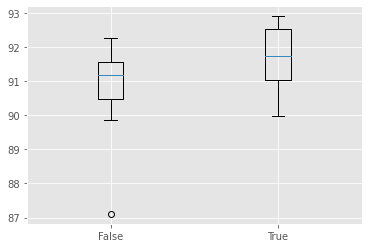

In [32]:
# run the experiment
n_params = [False, True]
run_experiment(n_params)

### 필터수  
추후 해볼 것

### 커널 사이즈  
추후 해볼 것

### Multi-Headed Convolutional Neural Network

커널 사이즈가 각각 3, 5, 11인 모델을 사용하여 시퀀스 데이터를 각각 다른 resolution으로 읽고 해석하도록 하자.

In [36]:
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    
    inputs1 = Input(shape=(n_timesteps, n_features))
    conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    
    inputs2 = Input(shape=(n_timesteps,n_features))
    conv2 = Conv1D(filters=64, kernel_size=5, activation='relu')(inputs2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # head 3
    inputs3 = Input(shape=(n_timesteps,n_features))
    conv3 = Conv1D(filters=64, kernel_size=11, activation='relu')(inputs3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(100, activation='relu')(merged)
    outputs = Dense(n_outputs, activation='softmax')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    
    # save a plot of the model
    plot_model(model, show_shapes=True, to_file='multichannel.png')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit([trainX,trainX,trainX], trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate([testX,testX,testX], testy, batch_size=batch_size, verbose=0)
    return accuracy

In [37]:
def summarize_results(scores):
	print(scores)
	m, s = np.mean(scores), np.std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [38]:
def run_experiment(repeats=10):
	# load data
	trainX, trainy, testX, testy = load_dataset()
	# repeat experiment
	scores = list()
	for r in range(repeats):
		score = evaluate_model(trainX, trainy, testX, testy)
		score = score * 100.0
		print('>#%d: %.3f' % (r+1, score))
		scores.append(score)
	# summarize results
	summarize_results(scores)

In [41]:
run_experiment()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
>#1: 93.315
>#2: 91.381
>#3: 91.076
>#4: 92.094
>#5: 90.261
>#6: 92.433
>#7: 91.551
>#8: 89.990
>#9: 90.227
>#10: 92.195
[93.31523776054382, 91.3810670375824, 91.07567071914673, 92.09365248680115, 90.26128053665161, 92.43298172950745, 91.55073165893555, 89.98982310295105, 90.22734761238098, 92.19545125961304]
Accuracy: 91.452% (+/-1.030)
